## Haplotype linkage and clustering of the *Vgsc* in Tanzanian *An. funestus*
### Identification of knock-down resistance (*Kdr*) in Tanzanian *Anopheles. funestus*, 2023.
### Tristan P.W. Dennis, Joel O. Odero 22.11.23

In [294]:
#import libs
import numpy as np
import pandas as pd
import malariagen_data
import allel
import xarray as xr
import malariagen_data
from typing import List
import plotly.express as px
import ipyleaflet
import bokeh
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import _convert_to_double
from scipy.spatial import distance
from scipy.cluster.hierarchy import _hierarchy
import seaborn as sns
import scipy
import matplotlib as mpl

In [279]:
af1 = malariagen_data.Af1(pre=True,results_cache='~/Projects/kdr_funestus_report_2023/data')
#load metadata for all sample sets
sample_sets = ['1236-VO-TZ-OKUMU-VMF00252','1236-VO-TZ-OKUMU-VMF00248','1236-VO-TZ-OKUMU-VMF00261', '1236-VO-TZ-OKUMU-OKFR-TZ-2008', '1236-VO-TZ-OKUMU-VMF00090']
df_samples = af1.sample_metadata(sample_sets=sample_sets)
df_samples = df_samples[df_samples.admin1_name != 'Kigoma']

Load sample metadata:   0%|          | 0/5 [00:00<?, ?it/s]

In [280]:
#plot vgsc transcript
af1.plot_transcript('LOC125769886_t4')

Figure(id='2579', ...)

In [281]:
#define pop colours
poppalkeys = df_samples.admin1_name.unique()
poppalvals = ['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c','#fdbf6f','#ff7f00','#cab2d6','#6a3d9a']
pop_colours = dict(zip(sorted(poppalkeys), poppalvals))

In [221]:
#LD analysis of vgsc gene 

#get snp data
vgsc_genos = af1.snp_genotypes(
    region='3RL:44105643-44156624',
    sample_query="sample_set == ['1236-VO-TZ-OKUMU-VMF00252','1236-VO-TZ-OKUMU-VMF00248','1236-VO-TZ-OKUMU-VMF00261', '1236-VO-TZ-OKUMU-OKFR-TZ-2008', '1236-VO-TZ-OKUMU-VMF00090'] & admin1_name != 'Kigoma'",
)

#get variant data
vars = af1.snp_variants(
    region='3RL:44105643-44156624',
   # sample_query="sample_set == ['1236-VO-TZ-OKUMU-VMF00252','1236-VO-TZ-OKUMU-VMF00248','1236-VO-TZ-OKUMU-VMF00261', '1236-VO-TZ-OKUMU-OKFR-TZ-2008', '1236-VO-TZ-OKUMU-VMF00090']"
)

#compute variant positions and get positions corresponding to our vgsc snps of interest
varpos = vars['variant_position'].values
varvgsc = [44115564,44115768,44116128,44116334,44116923,44117167,44122391,44125475]
snp_indices = np.where(np.isin(varpos, varvgsc))[0]
kdr_genos = allel.GenotypeArray(vgsc_genos).take([9921, 10125, 10485, 10691, 11280, 11524, 16748, 19832], axis=0)

#calculate number of alternate alleles
kdr_numalt = kdr_genos.to_n_alt()

#infer LD and write
ld_r_mat = allel.rogers_huff_r_between(kdr_numalt, kdr_numalt)
df = pd.DataFrame(ld_r_mat)
df.to_csv("/Users/dennistpw/Projects/kdr_funestus_report_2023/data/kdrld.csv")

In [283]:
#subset variants to be only the positions we want

#defin dictionary of variants of interest (nonsynonymous mutations over 5%)
analysishaps = {'I2030V' : '44115564',
'G1962V' : '44115768',
'P1842S' : '44116128',
'N1773S' : '44116334',
'F1638Y' : '44116923',
'W1557R' : '44117167',
'G1144C' : '44122391',
'L976F' :  '44125475'}


In [309]:
#now let's do some clustering of haplotypes 

#get hap data
vgsc_haps = af1.haplotypes(
    region='3RL:44105643-44156624',
    sample_query="sample_set == ['1236-VO-TZ-OKUMU-VMF00252','1236-VO-TZ-OKUMU-VMF00248','1236-VO-TZ-OKUMU-VMF00261', '1236-VO-TZ-OKUMU-OKFR-TZ-2008', '1236-VO-TZ-OKUMU-VMF00090'] & admin1_name != 'Kigoma'",
)

#compute hap positions and get positions corresponding to our vgsc haps of interest
happos = vgsc_haps['variant_position'].values
varvgsc = [44116128,44116923,44117167,44125475]
hap_indices = np.where(np.isin(happos, varvgsc))[0]

#compute haplotypearray and keep missense muts 
gt = allel.GenotypeDaskArray(vgsc_haps["call_genotype"].data)
ht = gt.to_haplotypes().compute()
kdr_haps = ht.take(hap_indices.tolist(), axis=0)


In [300]:
def plot_missense_haplotypes(ax, h, mut_labels):
    h = h.copy()
    # colours for colormap
    mycol = ['r', 'w', 'k'] 
    # alter rows with kdr mutations for color map to pick up
#     known_muts = ['L995S (2984T>C)', 'L995F (2985A>T)', 'N1570Y (4708A>T)']
    known_muts = ['L976F', 'F1638Y','W1557R','P1842S']
    for mut in known_muts:
        if mut in mut_labels:
            h[mut_labels.index(mut)] *= -1

    # make colormap
    cake = mpl.colors.ListedColormap(mycol, name='mymap', N=3)
    # plot
    ax.pcolormesh(np.asarray(h[::-1]), cmap=cake, vmin=-1, vmax=1, zorder=-10)
        
    ax.set_yticks(np.arange(h.shape[0])+.5)
    lbl = [l for l in mut_labels[::-1]]
    ax.set_yticklabels(lbl, family='monospace', fontsize=6)
    ax.set_ylabel('Non-synonymous SNPs')
    
    for ytick in ax.get_yticklabels():
        if ytick.get_text() in known_muts:
            ytick.set_color('r')
    
    ax.hlines(np.arange(h.shape[0]+1), 0, h.shape[1], color='k', lw=.5)
    ax.set_xlim(0, h.shape[1])
    ax.set_ylim(0, h.shape[0])
    ax.yaxis.tick_left()
    ax.set_xticks([])
    # rasterize to avoid SVG antialiasing issues and reduce file size
    ax.set_rasterization_zorder(-5)

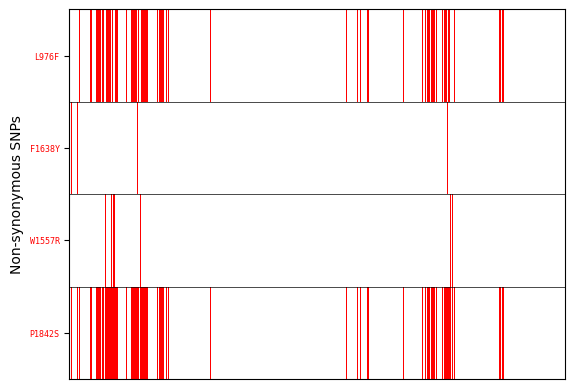

In [301]:
fig, ax = plt.subplots()
missense_mutations = ['L976F', 'F1638Y','W1557R','P1842S']
plot_missense_haplotypes(ax, kdr_haps, missense_mutations)

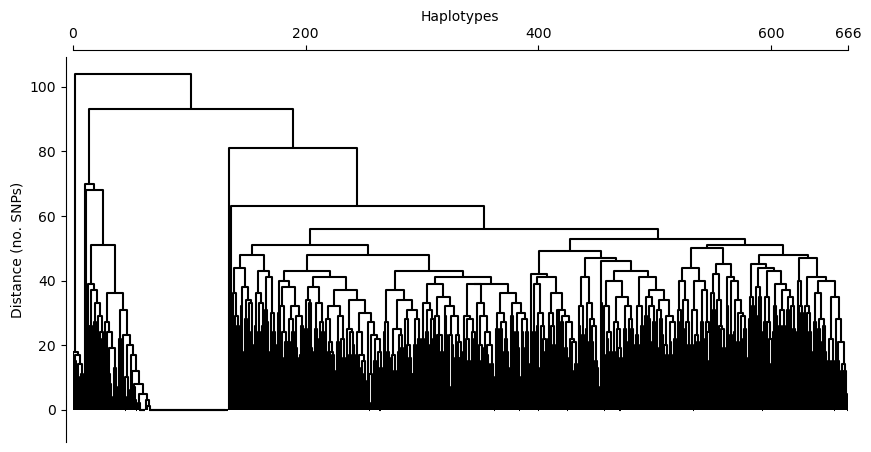

In [295]:
def plot_dendrogram(h, ax, method='complete', color_threshold=0, above_threshold_color='k'):
    
    # compute distance matrix
    dist = allel.pairwise_distance(h, 'hamming') * h.shape[0]

    # HACKING SCIPY TO GET TO OLD CLUSTERING METHOD
    # https://github.com/scipy/scipy/blob/v0.18.1/scipy/cluster/hierarchy.py#L470-L667
    # 1. fiddle with format
    y = _convert_to_double(np.asarray(dist, order='c'))
    # 2. get n
    n = int(distance.num_obs_y(dist))
    # 3. do clustering
    method = dict(single=0, complete=1)[method]
    z = _hierarchy.linkage(y, n, method)    

    # plot dendrogram
    sns.despine(ax=ax, offset=5, bottom=True, top=False)
    r = scipy.cluster.hierarchy.dendrogram(z, no_labels=True, count_sort=True, 
                                           color_threshold=color_threshold, 
                                           above_threshold_color=above_threshold_color,
                                           ax=ax)
    xmin, xmax = ax.xaxis.get_data_interval()
    xticklabels = np.array(list(range(0, h.shape[1], 200)) + [h.shape[1]])
    xticks = xticklabels / h.shape[1]
    xticks = (xticks * (xmax - xmin)) + xmin
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels)
    ax.set_xlabel('Haplotypes')
    ax.xaxis.set_label_position('top')
    ax.set_ylim(bottom=-10)
#     ax.set_xlim(left=-10)
    ax.set_ylabel('Distance (no. SNPs)')
    ax.autoscale(axis='x', tight=True)
    return z, r

fig, ax = plt.subplots(figsize=(10, 5))
plot_dendrogram(ht, ax);

In [258]:
#define hap and pop dfs for plotting
df_haps = df_samples.loc[df_samples.index.repeat(2)]
populations = df_samples.admin1_name
pop_labels = df_samples.admin1_name.values

In [302]:
def fig_hap_structure(h, h_display=None, mutations=None, vspans=[[]], cluster_labels=[], figsize=(10, 8), 
                      fn=None, dpi=150, height_ratios=(3, .2, 1.5, .2), hap_pops=None, legend=True):
    
    # create the figure
    fig = plt.figure(figsize=figsize)
    
    # define subplot layout
    gs_nrows = 4
    gs_ncols = 1
    gs = mpl.gridspec.GridSpec(gs_nrows, gs_ncols, hspace=0.04, wspace=0.04,
                               height_ratios=height_ratios)
    
    # dendrogram
    ax_dend = fig.add_subplot(gs[0, 0])
    z, r = plot_dendrogram(h, ax_dend, color_threshold=0)
    ax_dend.set_ylim(bottom=-5)
#     for xmin, xmax in vspans:
#         ax.add_patch(plt.Rectangle((xmin, 0), (xmax-xmin), 1,
#                                    facecolor='k', edgecolor='k', alpha=.1,
#                                    transform=ax.transAxes, zorder=20))
#     ax.vlines(vspans.flat, 0, 1, transform=ax.transAxes, linestyle=':')
    if legend:
        handles = [mpl.patches.Patch(color=pop_colours[pop], label=pop) for pop in poppalkeys]
        ax_dend.legend(handles=handles, loc='upper right', bbox_to_anchor=(1, 1), ncol=3)
    ax_dend.set_yticklabels(ax_dend.get_yticks().astype(int))
    ax_dend.xaxis.set_tick_params(length=3, pad=2)
    ax_dend.yaxis.set_tick_params(length=3, pad=2)

    # population colours
    ax_pops = fig.add_subplot(gs[1, 0])
    if hap_pops is None:
        hap_pops = df_haps.admin1_name.values
    x = hap_pops.take(r['leaves'])
    hap_clrs = [pop_colours[p] for p in x]
    ax_pops.broken_barh(xranges=[(i, 1) for i in range(h.shape[1])], yrange=(0, 1), color=hap_clrs);
    sns.despine(ax=ax_pops, offset=5, left=True, bottom=True)
    ax_pops.set_xticks([])
    ax_pops.set_yticks([])
    ax_pops.set_xlim(0, h.shape[1])
    ax_pops.yaxis.set_label_position('left')
    ax_pops.set_ylabel('Population', rotation=0, ha='right', va='center')

    # missense mutations
    if h_display is not None:
        ax_mut = fig.add_subplot(gs[2, 0])
        plot_missense_haplotypes(ax_mut, h_display.take(r['leaves'], axis=1), mutations)
        ax_mut.set_xticks([])
        ax_mut.yaxis.set_tick_params(length=3, pad=2)

    # KDR haplotype clusters
    ax_clu = fig.add_subplot(gs[3, 0])
    sns.despine(ax=ax_clu, bottom=True, left=True)
    ax_clu.set_xlim(0, h.shape[1])
    ax_clu.set_ylim(0, 1)
    for lbl, (xmin, xmax) in zip(cluster_labels, vspans):
        if lbl:
            # hack to get the "fraction" right, which controls length of bracket arms
            fraction = -20 / (xmax - xmin)
            ax_clu.annotate("", ha='left', va='center',
                            xy=(xmin, 1), xycoords='data',
                            xytext=(xmax, 1), textcoords='data',
                            arrowprops=dict(arrowstyle="-",
                                            connectionstyle="bar,fraction=%.4f" % fraction,
                                            ),
                            )
            ax_clu.text((xmax + xmin)/2, 0.2, lbl, va='top', ha='center', fontsize=6)
            ax_pops.vlines([xmin, xmax], 0, 1, linestyle=':')
            ax_mut.add_patch(plt.Rectangle((xmin, 0), (xmax-xmin), h_display.shape[0],
                             facecolor='k', edgecolor='k', alpha=.1,
                             zorder=20))
            ax_mut.vlines([xmin, xmax], 0, h_display.shape[0], linestyle=':')
    ax_clu.set_xticks([])
    ax_clu.set_yticks([])
    ax_clu.set_xlabel('$kdr$ haplotype clusters')
    
    if fn:
        fig.savefig(fn, jpeg_quality=100, dpi=dpi, bbox_inches='tight')
        
    return z, r

/var/folders/bs/sb5__dq153x37170dk1vr_2h0000gp/T/ipykernel_36128/4128140202.py:25: UserWarning:

FixedFormatter should only be used together with FixedLocator



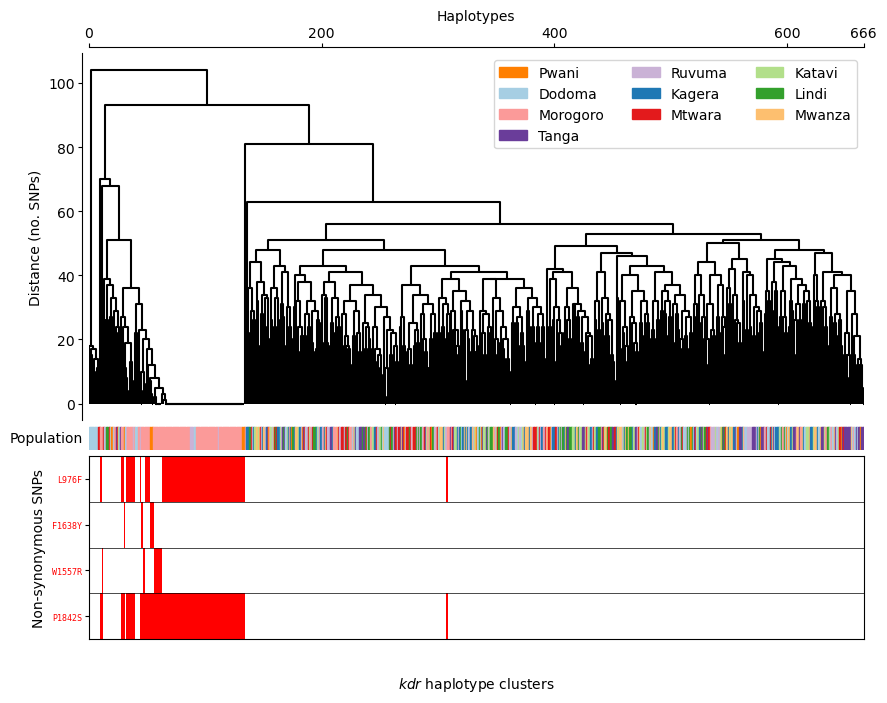

In [310]:
z, r = fig_hap_structure(ht, kdr_haps, missense_mutations)
